## Simple damped harmonic oscillator

This example notebook characterizes the slimplectic Galerkin-Gauss-Lobatto variational integrator with the simple damped harmonic oscillator, which has a known analytical solution. 

The conservative part $L$ of the total Lagrangian $\Lambda$ is
$$L = \frac{1}{2} m \dot{q}^2 - \frac{1}{2} k q^2$$
and the nonconservative part $K$ is
$$K = - \lambda \dot{q}_+ q_- \, .$$
The known analytical solution to the equations of motion is
$$q(t) = q(0)e^{-\lambda t/ 2} \cos \left( \Omega t + \phi(0) \right)$$ 
where 
$$\Omega = \sqrt{ \frac{k}{m} - \frac{\lambda^2 }{ 4} }$$
and the initial velocity $\dot{q}(0)$ is related to $\phi(0)$ through
$$\dot{q}(0) = - q(0) \left( \frac{ \lambda}{2} \cos \phi(0) + \Omega \sin \phi(0) \right).$$

In this notebook, we take $\lambda = 10^{-4}\sqrt{m k}$ though other choices are possible, of course. 

In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt
import slimplectic

In [2]:
# Set harmonic oscillator parameters
m = 1.0
k = 1.0
ll = 1e-4*np.sqrt(m*k)  # ll is $\lambda$ in the paper

### Slimplectic integration

In [3]:
# Create an instance of the GalerkinGaussLobatto class and call it `dho` for damped harmonic oscillator.
dho = slimplectic.GalerkinGaussLobatto('t', ['q'], ['v'])

In [4]:
# Define the conservative $L$ and nonconservative $K$ parts of the total Lagrangian $\Lambda$
L = 0.5*m*np.dot(dho.v, dho.v) - 0.5*k*np.dot(dho.q, dho.q)
K = -ll*np.dot(dho.vp, dho.qm)

print("L =", L)
print("K =", K)

L = -0.5*q**2 + 0.5*v**2
K = -0.0001*q_-*v_+


In [6]:
# Discretize the total Lagrangian using a 2nd order (r=0) explicit scheme.
# We select verbose output to show the discretization of the total Lagrangian and corresponding equations of motion.
dho.discretize(L, K, 0, method='explicit', verbose=True)

For Lagrangian:
	 L = - 0.5 q^{2} + 0.5 v^{2}
and K-potential:
	 K = - 0.0001 q_{-} v_{+}
********************
The Order 2 discretized Lagrangian is:
	 L_d^n = \frac{h_{{GGL}}}{2} \left(- \frac{{q^{{[n+1]}}}^{2}}{2} + \frac{\left({q^{{[n+1]}}} - {q^{{[n]}}}\right)^{2}}{2 h_{{GGL}}^{2}}\right) + \frac{h_{{GGL}}}{2} \left(- \frac{{q^{{[n]}}}^{2}}{2} + \frac{\left({q^{{[n+1]}}} - {q^{{[n]}}}\right)^{2}}{2 h_{{GGL}}^{2}}\right)
The Order 2 discretized K-potential is:
	 K_d^n = - \frac{{q^{{[n+1]}}}_{-}}{20000} \left({q^{{[n+1]}}}_{+} - {q^{{[n]}}}_{+}\right) - \frac{{q^{{[n]}}}_{-}}{20000} \left({q^{{[n+1]}}}_{+} - {q^{{[n]}}}_{+}\right)
********************
The Order 2 Discretized Equations of motion:
	0 = \pi^{{[n]}}_{q} - \frac{h_{{GGL}} {q^{{[n]}}}}{2} - \frac{{q^{{[n+1]}}}}{20000} + \frac{{q^{{[n]}}}}{20000} - \frac{{q^{{[n+1]}}}}{h_{{GGL}}} + \frac{{q^{{[n]}}}}{h_{{GGL}}}
	0 = - \pi^{{[n+1]}}_{q} - \frac{h_{{GGL}} {q^{{[n+1]}}}}{2} - \frac{{q^{{[n+1]}}}}{20000} + \frac{{q^{{[n]}}}}{2

In [6]:
# Specify time samples at which the numerical solution is to be given initial data

# Time samples
dt = 0.1*np.sqrt(m/k)
tmax = 10000*np.sqrt(m/k)
t = dt*np.arange(0, int(tmax/dt)+1)

# Initial data (at t=0)
q0 = [1.]
pi0 = [0.25*dt*k]
# The initial condition for pi0 is chosen because the 2nd order slimplectic method 
# has $\pi$ actually evaluated at the mid-step, and it needs corrections to that effect.
# Otherwise, the phase is off and the energy has a constant offset. 

In [7]:
# Now integrate the 2nd order slimplectic integrator
q_slim2, pi_slim2 = dho.integrate(q0, pi0, t)

In [8]:
# For a 4th order (r=1) explicit scheme we run
dho.discretize(L, K, 1, method='explicit')

# ...and then integrate to get the corresponding numerical solution
pi0 = [0.]
q_slim4, pi_slim4 = dho.integrate(q0, pi0, t)

### Runge-Kutta integration

Generate the 2nd and 4th order Runge-Kutta solutions to compare below with output from the slimplectic integrators.

In [9]:
# Instantiate the 2nd and 4th order Runge-Kutta classes
rk2 = slimplectic.RungeKutta2()
rk4 = slimplectic.RungeKutta4()

# Define the derivative operator for a simple damped harmonic oscillator
def dydt(time, y):
    deriv = np.zeros(2)
    [q_x, v_x] = y
    deriv[0] = v_x
    deriv[1] = - (k/m)*q_x - (ll/m)*v_x 
    return deriv

# Integrate
v0 = [0.]
q_rk2, v_rk2 = rk2.integrate(q0, v0, t, dydt)
q_rk4, v_rk4 = rk4.integrate(q0, v0, t, dydt)

# Please note that q and pi are outputs of the slimplectic integration, 
# while q and v are output from the Runge-Kutta integrators.

### Comparison plots

Plot the oscillator amplitude $q(t)$ for the 2nd and 4th order slimplectic and RK integrators along with the analytical solution.

In [10]:
# Analytical solution
Omega = np.sqrt(k/m - ll**2/4.)
phi0 = - np.arctan(-ll/(2.*Omega))    

def q(time):
    """Analytical solution for simple damped harmonic oscillator amplitude with q0=1, v0=0"""
    return np.exp(-ll*time/2.)*np.cos(Omega*time + phi0)

def v(time):
    """Analytical solution for simple damped harmonic oscillator velocity with q0=1, v0=0"""
    return np.exp(-ll*time/2.)*( -ll/2.*np.cos(Omega*time+phi0) - Omega*np.sin(Omega*time+phi0) )

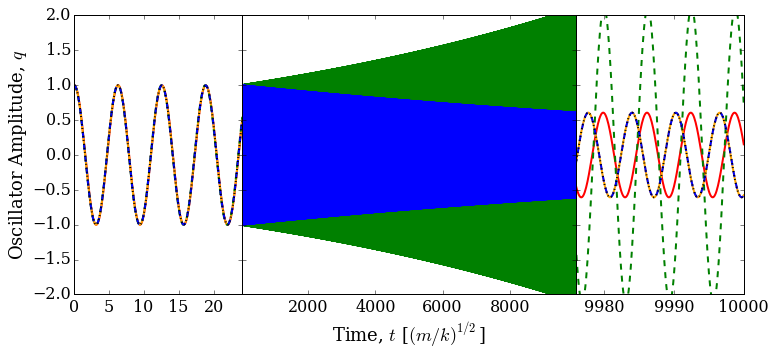

In [11]:
fig1 = plt.figure(figsize=(12,5), dpi=800)
fig1.subplots_adjust(wspace=0.05)

# Early times...
ax1a = fig1.add_subplot(1,4,1)
ax1a.set_ylim(-2, 2)
ax1a.set_xlim(0,24)
ax1a.plot(t, q_slim2[0], 'r-', linewidth=2.0, rasterized=True)
ax1a.plot(t, q_slim4[0], color='orange', linewidth=2.0, rasterized=True)
ax1a.plot(t, q_rk2[0], 'g--', linewidth=2.0, rasterized=True)
ax1a.plot(t, q_rk4[0], 'b--', linewidth=2.0, rasterized=True)
ax1a.plot(t, q(t), 'k:', linewidth=2.0, rasterized=True)

# Middle times...
ax1b = fig1.add_subplot(1,4,(2,3))
plt.setp(ax1b.get_yticklabels(), visible=False)
ax1b.set_ylim(-2, 2)
ax1b.set_xlim(24.9,9975.9)
ax1b.plot(t, q_slim2[0], linewidth=2.0, linestyle='-', color='red', rasterized=True)
ax1b.plot(t, q_slim4[0], linewidth=2.0, linestyle='-', color='orange', rasterized=True)
ax1b.plot(t, q_rk2[0], linewidth=2.0, linestyle='--', color='g', rasterized=True)
ax1b.plot(t, q_rk4[0], linewidth=2.0, linestyle='--', color='blue', rasterized=True)

# Late times...
ax1c = fig1.add_subplot(1,4,4)
plt.setp(ax1c.get_yticklabels(), visible=False)
ax1c.set_ylim(-2, 2)
ax1c.set_xlim(9976,10000)
ax1c.plot(t, q_slim2[0], linewidth=2.0, linestyle='-', color='red', rasterized=True)
ax1c.plot(t, q_slim4[0], linewidth=2.0, linestyle='-', color='orange', rasterized=True)
ax1c.plot(t, q_rk2[0], linewidth=2.0, linestyle='--', color='g', rasterized=True)
ax1c.plot(t, q_rk4[0], linewidth=2.0, linestyle='--', color='blue', rasterized=True)
ax1c.plot(t, q(t), 'k:', linewidth=2.0, rasterized=True)

ax1a.tick_params(axis='both', which='major', labelsize=16)
ax1b.tick_params(axis='both', which='major', labelsize=16)
ax1c.tick_params(axis='both', which='major', labelsize=16)
ax1c.set_xticks([9980, 9990, 10000])

ax1b.set_xlabel('Time, $t$ [$(m/k)^{1/2}$]', fontsize=18)
ax1a.set_ylabel('Oscillator Amplitude, $q$', fontsize=18)

In [12]:
#fig1.savefig("plot_path" + "DampSimpleCombined.pdf", transparent=True,bbox_inches='tight', dpi=500)

Let's see how the oscillator's energy changes with time according to the different orders and integration schemes. The energy is
$$E = \frac{1}{2} m \dot{q}^2 + \frac{1}{2} k q^2$$
and changes in time according to
$$\frac{ dE}{dt} = - \lambda \dot{q}^2.$$

To quantify the errors incurred by discretization and subsequent numerical integration, we define the fractional or relative energy difference as $\delta E / E = ( E_X - E )/ E$ where $E_X$ is the energy as measured by integrator $X$ with $X \in \{ {\rm Slim2,~Slim4,~RK2,~RK4} \}$.

In [13]:
# Energy function
def Energy(q, v):
    return 0.5*m*v**2 + 0.5*k*q**2

# Energies from the analytic solution and from different integrators
E = Energy(q(t), v(t))

E_slim2 = Energy(q_slim2[0], pi_slim2[0]/m)
E_slim4 = Energy(q_slim4[0], pi_slim4[0]/m)

E_rk2 = Energy(q_rk2[0], v_rk2[0])
E_rk4 = Energy(q_rk4[0], v_rk4[0])

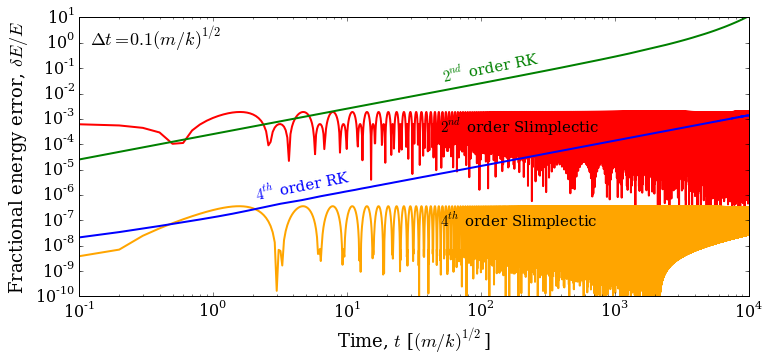

In [14]:
fig2 = plt.figure(figsize=(12,5), dpi=500)

ax2 = fig2.add_subplot(1,1,1)
ax2.set_ylim(1e-10, 1e1)
ax2.set_xlim(0.1, 10000)

ax2.loglog(t, np.abs(E_slim2/E-1.), 'r-', linewidth=2.0, rasterized=True)
ax2.loglog(t, np.abs(E_slim4/E-1.), color='orange', linestyle='-', linewidth=2.0, rasterized=True)
ax2.loglog(t, np.abs(E_rk2/E-1.), 'g--', linewidth=2.0, rasterized=True)
ax2.loglog(t, np.abs(E_rk4/E-1.), 'b--', linewidth=2.0, rasterized=True)

ax2.set_xlabel('Time, $t$ [$(m/k)^{1/2}$]', fontsize=18)
ax2.set_ylabel('Fractional energy error, $\delta E/E$', fontsize=18)

ax2.text(0.12, 0.75, r'$\Delta t = 0.1 (m/k)^{1/2}$', fontsize=18, color='k')
ax2.text(50, 3e-4, r'$2^{nd}$ order Slimplectic', fontsize=15, color='k')
ax2.text(50, 6e-8, r'$4^{th}$ order Slimplectic', fontsize=15, color='black')
ax2.text(2, 3e-6, r'$4^{th}$ order RK', fontsize=15, color='b', rotation=11)
ax2.text(50, 1.5e-1, r'$2^{nd}$ order RK', fontsize=15, color='g', rotation=11)

ax2.tick_params(axis='both', which='major', labelsize=16)

In [15]:
#fig2.savefig(plot_path + "DampSimpleELog.pdf", transparent=True,bbox_inches='tight', dpi=300)